In [18]:
# Imports
import numpy as np
import pandas as pd
import itertools
import pickle
import joblib

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from forward_selection import forward_selection

In [19]:
# Load data
df = pd.read_excel("data/Realized Schedule 20210101-20220208.xlsx")

# Remove rows with missing values
df.dropna(inplace=True)

print(df.head())

         ScheduleTime Airline  FlightNumber Destination AircraftType  \
0 2021-01-01 06:35:00      IA           874         DEN          73W   
1 2021-01-01 10:35:00      JZ           818         YHM          AT7   
2 2021-01-01 12:05:00      IA           876         DEN          73W   
3 2021-01-01 13:20:00      CN           514         EST          AT7   
4 2021-01-01 14:20:00      LJ          3140         DEN          32A   

  FlightType Sector  SeatCapacity  LoadFactor  
0          J     US           142    0.408451  
1          J     CA            74    0.189189  
2          J     US           142    0.570423  
3          J     US            72    0.333333  
4          J     US           186    0.204301  


### Exploratory analysis of the attributes

In [20]:
airlines = df['Airline'].unique()
print("Num airlines :", len(airlines))

flightnum = df['FlightNumber'].unique()
print("Num flight num :", len(flightnum))

aircraft = df['AircraftType'].unique()
print("Num aircraft type :", len(aircraft))

flighttype = df['FlightType'].unique()
print("Num flight type :", len(flighttype))

sectors = df['Sector'].unique()
print("Num sectors :", len(sectors))

seatcap = df['SeatCapacity'].unique()
print("Num seat capacities :", len(seatcap))

dest = df['Destination'].unique()
print("Num destinations :", len(dest))

Num airlines : 95
Num flight num : 807
Num aircraft type : 56
Num flight type : 3
Num sectors : 12
Num seat capacities : 132
Num destinations : 230


In [21]:
print(flighttype)
print(df[df['FlightType']=='G'])
print("We have one Flight with flight type G")

['J' 'C' 'G']
             ScheduleTime Airline  FlightNumber Destination AircraftType  \
35822 2022-02-06 19:30:00      OF           575         OTH          32Q   

      FlightType Sector  SeatCapacity  LoadFactor  
35822          G     US           160     0.45625  
We have one Flight with flight type G


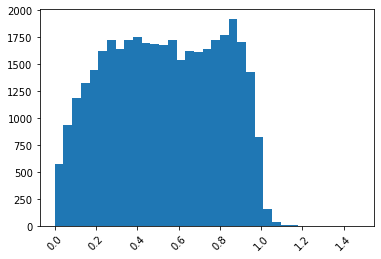

In [22]:
count = df['LoadFactor'].count()
bn = int(1 + 3.322*np.log(count))

plt.hist(df['LoadFactor'], bins = bn)
plt.xticks(rotation=45)
#plt.set_title("Histogram of load factors over all flights")
plt.show()

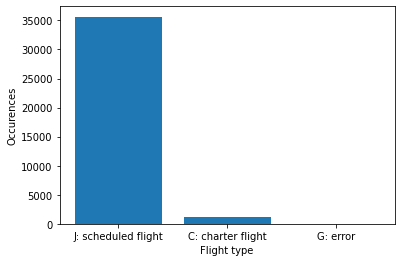

In [23]:
per_flighttype = [None for _ in range(len(flighttype))]
for i,tp in enumerate(flighttype):
    per_flighttype[i] = df[df.FlightType == tp].shape[0]

fig, ax = plt.subplots(1, 1)
plt.bar(["J: scheduled flight", "C: charter flight", "G: error"], per_flighttype)
ax.set_xlabel("Flight type")
ax.set_ylabel("Occurences")
plt.show()

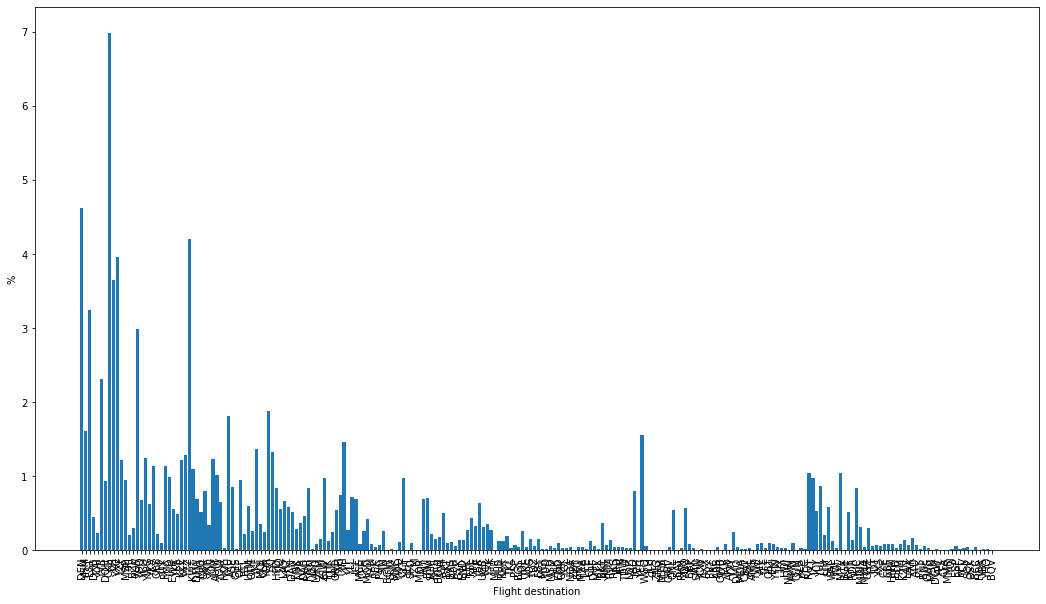

In [24]:
tt_flights = df.shape[0]

per_dest = [None for _ in range(len(dest))]
for i,destination in enumerate(dest):
    per_dest[i] = df[df.Destination == destination].shape[0]/tt_flights*100

fig, ax = plt.subplots(1, 1, figsize=(18,10))
plt.bar(dest, per_dest)
plt.xticks(rotation=90)
ax.set_xlabel("Flight destination")
ax.set_ylabel("%")
plt.show()

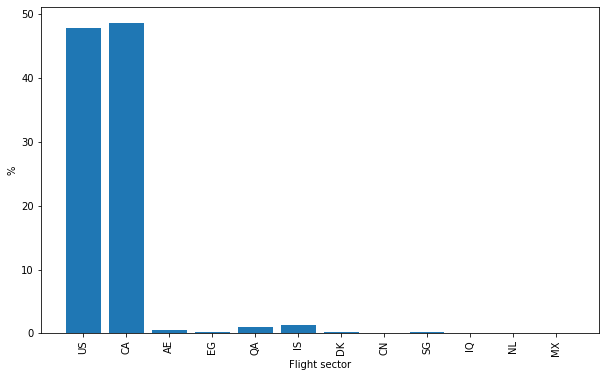

In [25]:
per_sect = [None for _ in range(len(sectors))]
for i,sect in enumerate(sectors):
    per_sect[i] = df[df.Sector == sect].shape[0]/tt_flights*100

fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.bar(sectors, per_sect)
plt.xticks(rotation=90)
ax.set_xlabel("Flight sector")
ax.set_ylabel("%")
plt.show()

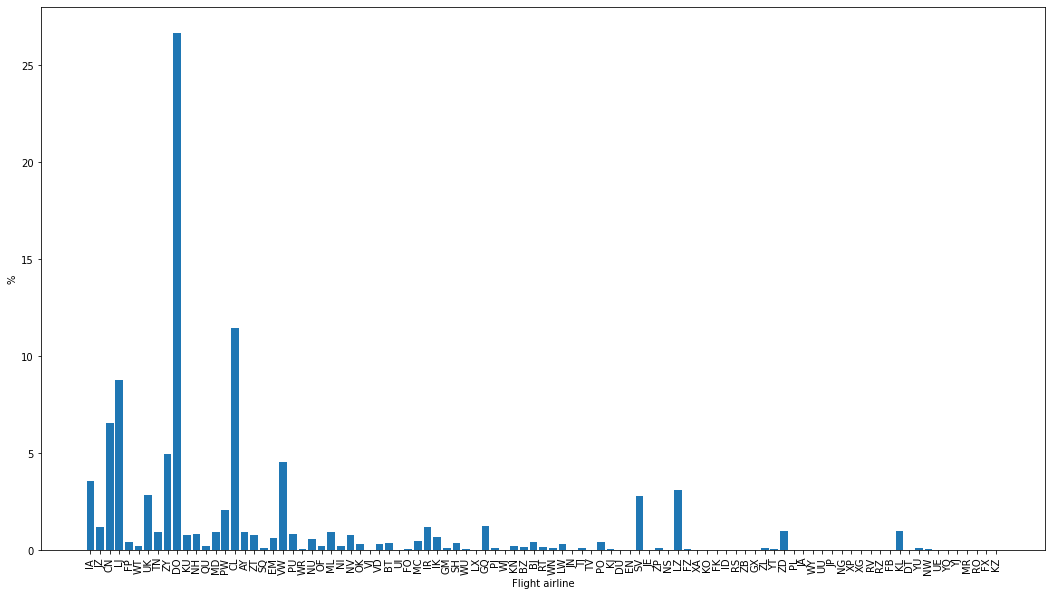

In [26]:
per_airline = [None for _ in range(len(airlines))]
for i,airline in enumerate(airlines):
    per_airline[i] = df[df.Airline == airline].shape[0]/tt_flights*100

fig, ax = plt.subplots(1, 1, figsize=(18,10))
plt.bar(airlines, per_airline)
plt.xticks(rotation=90)
ax.set_xlabel("Flight airline")
ax.set_ylabel("%")
plt.show()

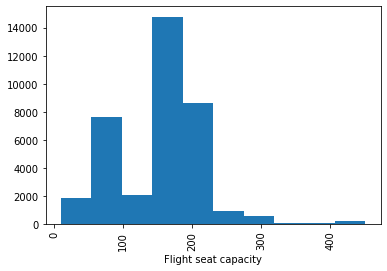

In [27]:
fig, ax = plt.subplots(1, 1)
plt.hist(df.SeatCapacity)
plt.xticks(rotation=90)
ax.set_xlabel("Flight seat capacity")
plt.show()

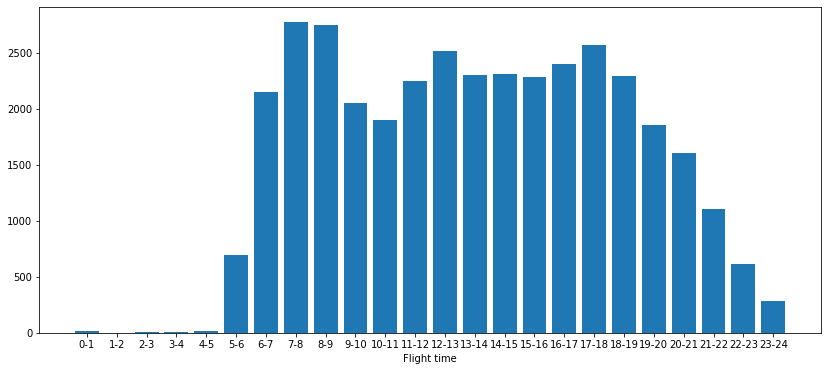

In [28]:
time = [None for i in range(24)]

hours = pd.to_datetime(df['ScheduleTime']).dt.hour

for i in range(24):
    def good_hour(x):
        return x == i
    
    time[i] = len(list(filter(good_hour, hours)))
    
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.bar([str(i) + "-" + str(i+1) for i in range(24)], time)
ax.set_xlabel("Flight time")
plt.show()

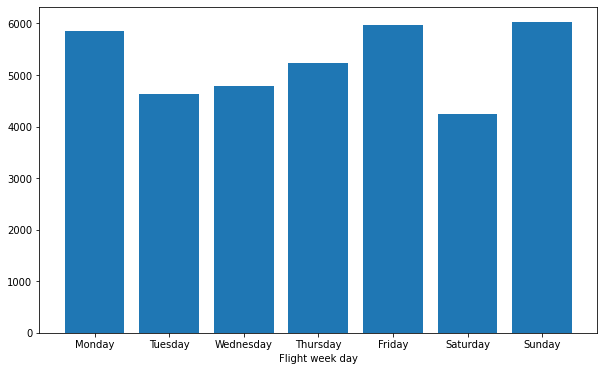

In [29]:
weekDays = pd.to_datetime(df.ScheduleTime).dt.weekday
per_wd = [None for i in range(7)]

for i in range(7):
    def good_day(x):
        return x == i
    
    per_wd[i] = len(list(filter(good_day, weekDays)))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.bar(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], per_wd)
ax.set_xlabel("Flight week day")
plt.show()

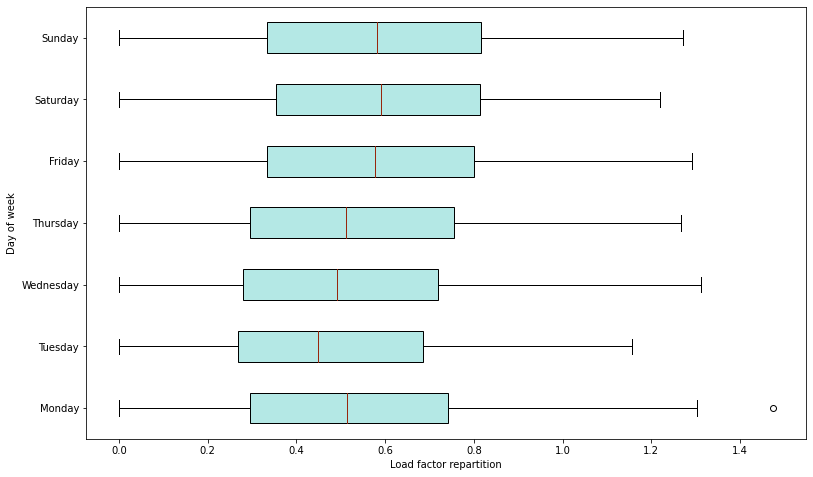

In [30]:
df['weekDay'] = pd.to_datetime(df['ScheduleTime']).dt.weekday
per_weekDay = [None for i in range(7)]

for i in range(7):
    per_weekDay[i] = df[df.weekDay == i]['LoadFactor']


fig = plt.figure(figsize =(10, 6))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('Load factor repartition')
ax.set_ylabel('Day of week')
ax.boxplot(per_weekDay, vert=False, patch_artist=True, boxprops=dict(facecolor='#b4e8e5'), medianprops=dict(color='#97260c'))
plt.yticks([k for k in range(1, 8)], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.show()

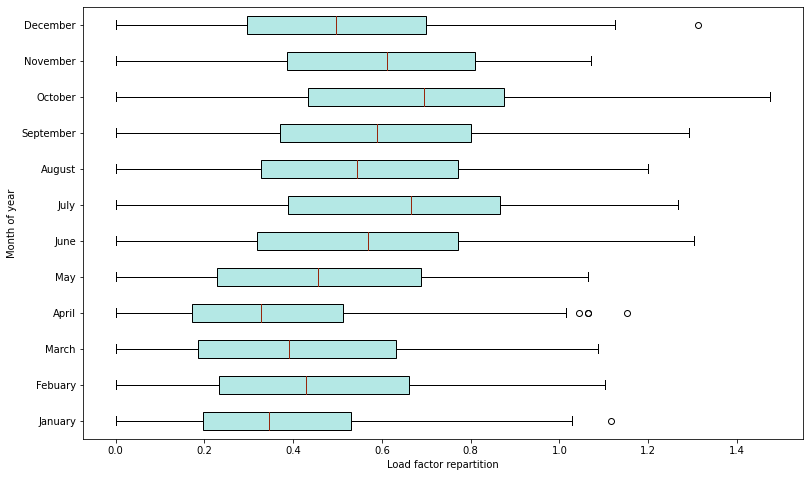

In [31]:
df['month'] = pd.to_datetime(df['ScheduleTime']).dt.month
per_month = [None for i in range(12)]

for i in range(1, 13):
    per_month[i-1] = df[df.month == i]['LoadFactor']


fig = plt.figure(figsize =(10, 6))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('Load factor repartition')
ax.set_ylabel('Month of year')
ax.boxplot(per_month, vert=False, patch_artist=True, boxprops=dict(facecolor='#b4e8e5'), medianprops=dict(color='#97260c'))
plt.yticks([k for k in range(1, 13)], ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])

plt.show()

### Load and preprocess the data

In [32]:
#############################
########Preprocessing########
#############################
# Change flight type G to flight type J
df.loc[(df.FlightType == "G"), "FlightType"] = "J"

#Convert schedule time to different columns
# Include month, year, day and weekday in the dataset
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.year.rename("Year")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.month.rename("Month")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.week.rename("Week")], axis=1) # Remove isocalendar if error
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.day.rename("Day")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.weekday.rename("Weekday")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.hour.rename("Hour")], axis=1)

# Include dummy variables for categorical features
cols = ["Airline", "Destination", "FlightType", "Sector"]
col_prefix = ["AIR", "DEST", "FLT", "SECT"]
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
cols_to_drop = ["FlightNumber", "AircraftType", "ScheduleTime", "Weekday"]

for i, col in enumerate(cols):
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col_prefix[i])], axis=1)

weekday_df = pd.get_dummies(df.Weekday)
weekday_df.columns = weekdays

df = pd.concat([df, weekday_df], axis=1)

df.drop(cols, axis=1, inplace=True)
df.drop(cols_to_drop, axis=1, inplace=True)

print(df.columns)
print(df.shape)



Index(['SeatCapacity', 'LoadFactor', 'weekDay', 'month', 'Year', 'Month',
       'Week', 'Day', 'Hour', 'AIR_AY',
       ...
       'SECT_QA', 'SECT_SG', 'SECT_US', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday'],
      dtype='object', length=355)
(36768, 355)


C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\2150359137.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.week.rename("Week")], axis=1) # Remove isocalendar if error


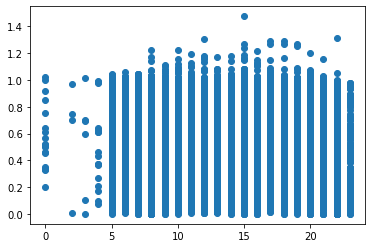

In [33]:
plt.scatter(df["Hour"], df["LoadFactor"])
plt.show()

In [34]:
# Extract features and targets
X = df.drop(["LoadFactor"], axis=1)
y = df.LoadFactor

# Perform train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1405)

### Model selection part
In this part we try to fit different models to our data : 
1. Forward selection
2. Backward selection
3. Decision tree
4. K-Nearest Neighbours
5. Ridge regression
6. Lasso regression
7. Elastic net regression


#### Forward selection

In [35]:
# Extract features using forward selection
forward_selection_features = forward_selection(X_train, y_train, num_of_features=100)
print(X_train.columns[forward_selection_features])

Index(['AIR_DO', 'month', 'FLT_C', 'AIR_SH', 'weekDay', 'AIR_KL', 'DEST_YXU',
       'AIR_SV', 'AIR_TN', 'DEST_YLW', 'DEST_AIY', 'AIR_VW', 'AIR_LJ',
       'DEST_GBR', 'DEST_YXC', 'DEST_YXJ', 'DEST_YXE', 'DEST_KWT', 'DEST_YYJ',
       'DEST_DAB', 'DEST_YLL', 'DEST_ORD', 'Monday', 'AIR_NU', 'DEST_YJO',
       'DEST_YXN', 'AIR_IA', 'SECT_CA', 'Day', 'DEST_MCE', 'DEST_PHX',
       'DEST_UGB', 'DEST_AUM', 'DEST_ONL', 'DEST_HFD', 'DEST_EWR', 'DEST_CPH',
       'DEST_LUL', 'DEST_OFF', 'DEST_CKE', 'DEST_BOW', 'DEST_SUD', 'AIR_CL',
       'AIR_FP', 'AIR_YU', 'AIR_LZ', 'AIR_BJ', 'DEST_WGO', 'AIR_UI',
       'DEST_PTL', 'AIR_BT', 'DEST_YXT', 'DEST_YEG', 'DEST_RUT', 'DEST_YFI',
       'DEST_CWS', 'AIR_NI', 'DEST_CYT', 'SECT_US', 'AIR_ZT', 'DEST_EST',
       'AIR_CN', 'DEST_MOD', 'DEST_YKF', 'Week', 'DEST_EKO', 'AIR_IK',
       'DEST_DGW', 'DEST_LAX', 'DEST_TXK', 'DEST_BNL', 'DEST_ESP', 'AIR_VJ',
       'DEST_YBR', 'SeatCapacity', 'DEST_DEN', 'DEST_YHM', 'DEST_YKK',
       'AIR_PJ', 'DEST_ZSW', 'A

In [36]:
# Perform linear regression with the forward selected features
X_forward_sel = X_train.iloc[:, forward_selection_features]
X_val_sel = X_val.iloc[:, forward_selection_features]
model = LinearRegression()
model.fit(X_forward_sel, y_train)
joblib.dump(model, "./models/for_sel_model.sav")
y_hat = model.predict(X_val_sel)
print(y_hat[:10])
print(y_val[:10].to_numpy())
RMSE = np.sqrt(np.mean((y_hat - y_val)**2))
acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')

print("\nMSE of LR with forward selection :", mean_squared_error(y_val, y_hat))

[0.33440458 0.6336412  0.7340111  0.68578338 0.18891979 0.24985272
 0.50527067 0.45843904 0.72426759 0.11549906]
[0.24381625 0.68783069 0.94166667 0.87777778 0.26666667 0.19642857
 0.95       0.58602151 0.47619048 0.13333333]
Accuracy per flight: [0.62845659 0.92121683 0.77948081 ... 0.48904199 0.73739233 0.91419877]
Total accuracy: 0.3872677729995066

MSE of LR with forward selection : 0.04142346861614486


C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\1756655582.py:11: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())


#### Backward selection

In [37]:
# Ectract features using backward selection
model = LinearRegression()
f_selector = RFE(model, n_features_to_select=100, step=1)
f_selector.fit(X_train, y_train)
print(X.columns[f_selector.support_])

Index(['weekDay', 'month', 'Month', 'AIR_AY', 'AIR_BJ', 'AIR_BT', 'AIR_BZ',
       'AIR_CL', 'AIR_CN', 'AIR_DO', 'AIR_DU', 'AIR_EM', 'AIR_FB', 'AIR_FO',
       'AIR_FX', 'AIR_FZ', 'AIR_GM', 'AIR_GQ', 'AIR_IA', 'AIR_IK', 'AIR_IR',
       'AIR_JA', 'AIR_JN', 'AIR_JP', 'AIR_JZ', 'AIR_KJ', 'AIR_KL', 'AIR_KN',
       'AIR_KO', 'AIR_KU', 'AIR_KZ', 'AIR_LJ', 'AIR_LW', 'AIR_LX', 'AIR_LZ',
       'AIR_MC', 'AIR_MD', 'AIR_ML', 'AIR_MR', 'AIR_NG', 'AIR_NH', 'AIR_NS',
       'AIR_NV', 'AIR_NW', 'AIR_OF', 'AIR_OK', 'AIR_PJ', 'AIR_PL', 'AIR_PO',
       'AIR_PU', 'AIR_PW', 'AIR_QU', 'AIR_RS', 'AIR_RT', 'AIR_SQ', 'AIR_SV',
       'AIR_TJ', 'AIR_TN', 'AIR_TV', 'AIR_UE', 'AIR_UI', 'AIR_UK', 'AIR_VD',
       'AIR_VW', 'AIR_WJ', 'AIR_WN', 'AIR_WR', 'AIR_WU', 'AIR_WY', 'AIR_XA',
       'AIR_XP', 'AIR_YJ', 'AIR_YQ', 'AIR_YT', 'AIR_YU', 'AIR_ZD', 'AIR_ZL',
       'AIR_ZP', 'AIR_ZT', 'AIR_ZY', 'DEST_AMS', 'DEST_BGW', 'DEST_CLR',
       'DEST_CPH', 'DEST_DXB', 'DEST_UTM', 'SECT_CA', 'SECT_CN', 'SECT_EG',
     

In [38]:
backward_selected_features = X_train.columns[f_selector.support_]
print(backward_selected_features)
X_backward_sel = X_train.loc[:, backward_selected_features]
X_val_sel = X_val.loc[:, backward_selected_features]
model = LinearRegression()
model.fit(X_backward_sel, y_train)
joblib.dump(model, "./models/back_sel_model.sav")
y_hat_BS = model.predict(X_val_sel)
acc_per_flight = np.ones(len(y_hat_BS)) - np.abs((y_val.to_numpy() - y_hat_BS) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')


print("\nMSE of LR with backward selection :", mean_squared_error(y_val, y_hat_BS))

Index(['weekDay', 'month', 'Month', 'AIR_AY', 'AIR_BJ', 'AIR_BT', 'AIR_BZ',
       'AIR_CL', 'AIR_CN', 'AIR_DO', 'AIR_DU', 'AIR_EM', 'AIR_FB', 'AIR_FO',
       'AIR_FX', 'AIR_FZ', 'AIR_GM', 'AIR_GQ', 'AIR_IA', 'AIR_IK', 'AIR_IR',
       'AIR_JA', 'AIR_JN', 'AIR_JP', 'AIR_JZ', 'AIR_KJ', 'AIR_KL', 'AIR_KN',
       'AIR_KO', 'AIR_KU', 'AIR_KZ', 'AIR_LJ', 'AIR_LW', 'AIR_LX', 'AIR_LZ',
       'AIR_MC', 'AIR_MD', 'AIR_ML', 'AIR_MR', 'AIR_NG', 'AIR_NH', 'AIR_NS',
       'AIR_NV', 'AIR_NW', 'AIR_OF', 'AIR_OK', 'AIR_PJ', 'AIR_PL', 'AIR_PO',
       'AIR_PU', 'AIR_PW', 'AIR_QU', 'AIR_RS', 'AIR_RT', 'AIR_SQ', 'AIR_SV',
       'AIR_TJ', 'AIR_TN', 'AIR_TV', 'AIR_UE', 'AIR_UI', 'AIR_UK', 'AIR_VD',
       'AIR_VW', 'AIR_WJ', 'AIR_WN', 'AIR_WR', 'AIR_WU', 'AIR_WY', 'AIR_XA',
       'AIR_XP', 'AIR_YJ', 'AIR_YQ', 'AIR_YT', 'AIR_YU', 'AIR_ZD', 'AIR_ZL',
       'AIR_ZP', 'AIR_ZT', 'AIR_ZY', 'DEST_AMS', 'DEST_BGW', 'DEST_CLR',
       'DEST_CPH', 'DEST_DXB', 'DEST_UTM', 'SECT_CA', 'SECT_CN', 'SECT_EG',
     

C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\584120788.py:9: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat_BS)) - np.abs((y_val.to_numpy() - y_hat_BS) / y_val.to_numpy())


#### Decision tree

In [39]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
joblib.dump(dtree, "./models/dec_tree_model.sav")

y_hat_DT = dtree.predict(X_val)

print("MSE of decision tree :", mean_squared_error(y_val.to_numpy(), y_hat_DT))

acc_per_flight = np.ones(len(y_hat_DT)) - np.abs((y_val.to_numpy() - y_hat_DT) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')

MSE of decision tree : 0.0430464010133555
Accuracy per flight: [0.75362319 0.80769231 0.62536873 ... 0.52238806 0.99038462 0.94179894]
Total accuracy: 0.5358508077104226


C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\4033281742.py:9: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat_DT)) - np.abs((y_val.to_numpy() - y_hat_DT) / y_val.to_numpy())


#### KNN

In [40]:
K = 20
KNN = KNeighborsRegressor(n_neighbors = K, weights = 'uniform', metric = 'euclidean')
KNN.fit(X_train, y_train)

pred_knn = KNN.predict(X_val)

print("MSE of KNN :", mean_squared_error(y_val.to_numpy(), pred_knn))

MSE of KNN : 0.047820247138730024


In [41]:
Ks = [1, 2, 5, 10, 20, 30, 50, 70, 100]
val_errors = [None for _ in range(len(Ks))]
train_errors = [None for _ in range(len(Ks))]

for i,k in enumerate(Ks):
    KNN = KNeighborsRegressor(n_neighbors = k, weights = 'uniform', metric = 'euclidean')
    KNN.fit(X_train, y_train)
    pred_knn = KNN.predict(X_val)

    val_errors[i] = mean_squared_error(y_val.to_numpy(), pred_knn)
    train_errors[i] = mean_squared_error(y_train.to_numpy(), KNN.predict(X_train))

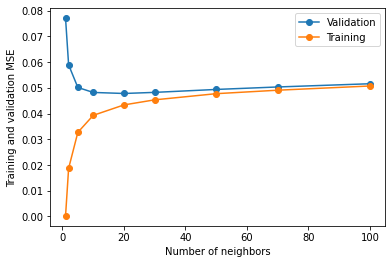

In [42]:
fig, ax = plt.subplots(1, 1)
plt.plot(Ks, val_errors, 'o-', label='Validation')
plt.plot(Ks, train_errors, 'o-', label='Training')
plt.legend()
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Training and validation MSE")
plt.show()

A more precise selection of k value : 

In [43]:
Ks = [k for k in range(5,21)]
K = 10
CV = KFold(n_splits=K)
val_errors = np.zeros([K, len(Ks)])
train_errors = np.zeros([K, len(Ks)])

# Perform cross validation to determine best number of neighbours
for i, (train_index, test_index) in enumerate(CV.split(X, y)):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index, :]
    y_test = y.iloc[test_index]

    # X_train = X_standardizer.fit_transform(X_train)
    # X_test = X_standardizer.transform(X_test)

    for j,k in enumerate(Ks):
        KNN = KNeighborsRegressor(n_neighbors = k, weights = 'uniform', metric = 'euclidean')
        KNN.fit(X_train, y_train)
        pred_knn = KNN.predict(X_test)

        val_errors[i, j] = mean_squared_error(y_test.to_numpy(), pred_knn)
        train_errors[i, j] = mean_squared_error(y_train.to_numpy(), KNN.predict(X_train))

Value of K with the smallest error : 20


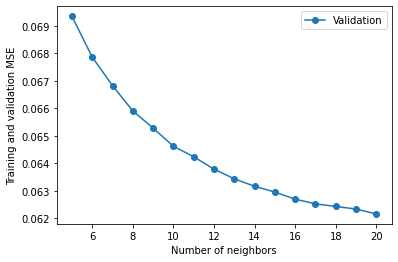

In [45]:
train_errors_mean = np.mean(train_errors, axis=0)
val_errors_mean = np.mean(val_errors, axis=0)

print("Value of K with the smallest error :", Ks[np.argmin(val_errors_mean)])

fig, ax = plt.subplots(1, 1)
plt.plot(Ks, val_errors_mean, 'o-', label='Validation')
plt.plot(Ks, train_errors_mean, 'o-', label='Training')
plt.legend()
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Training and validation MSE")
plt.show()



In [46]:
# Evaluate the KNN model

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1542)

model = KNeighborsRegressor(n_neighbors = Ks[np.argmin(val_errors_mean)], weights='uniform', metric='euclidean')
model.fit(X_train, y_train)
joblib.dump(model, "./models/KNN_reg_model.sav")
y_hat = model.predict(X_val)
MSE = mean_squared_error(y_val, y_hat)
print(f'MSE for KNN regression is {MSE}')
acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')

MSE for KNN regression is 0.04795542097164738
Accuracy per flight: [  0.20606061   0.97438017   0.823916   ...   0.98881476 -19.63976667
   0.78983891]
Total accuracy: 0.25031446336799207


C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\2223148964.py:12: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())


The selected value of k depends on the validation set. It varies from 7 to 12 usually.

### Ridge regression

In [47]:
# Define parameters
lambdas = np.logspace(-4, 2, 100)
K = 10
CV = KFold(n_splits=K)
train_errs = np.zeros([K, len(lambdas)])
val_errs = np.zeros([K, len(lambdas)])
X_standardizer = StandardScaler()
# Perform cross validation to determine best penalization parameter
for i, (train_index, test_index) in enumerate(CV.split(X, y)):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index, :]
    y_test = y.iloc[test_index]

    # X_train = X_standardizer.fit_transform(X_train)
    # X_test = X_standardizer.transform(X_test)

    for k, _lambda in enumerate(lambdas):
        model = Ridge(alpha=_lambda)
        model.fit(X_train, y_train)

        y_hat = model.predict(X_test)

        val_errs[i, k] = mean_squared_error(y_test, y_hat)
        train_errs[i, k] = mean_squared_error(y_train, model.predict(X_train))
    

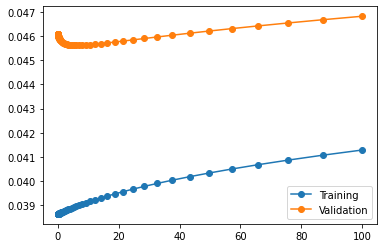

The optimal value of lambda for training is 0.0001
The optimal value of lambda for validation is 6.135907273413176


In [48]:
# Obtain the mean error of each lambda value
val_errors_mean = np.mean(val_errs, axis=0)
train_errors_mean = np.mean(train_errs, axis=0)
# Visualize the results
fig, ax = plt.subplots(1, 1)
plt.plot(lambdas, train_errors_mean, 'o-', label='Training')
plt.plot(lambdas, val_errors_mean, 'o-', label='Validation')
plt.legend()
plt.show()

print(f'The optimal value of lambda for training is {lambdas[np.argmin(train_errors_mean)]}')
print(f'The optimal value of lambda for validation is {lambdas[np.argmin(val_errors_mean)]}')





In [49]:
# Evaluate the model

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1703)

model = Ridge(alpha=lambdas[np.argmin(val_errors_mean)])
model.fit(X_train, y_train)
joblib.dump(model, "./models/ridge_reg_model.sav")
y_hat = model.predict(X_val)
MSE = mean_squared_error(y_val, y_hat)
print(f'MSE for ridge regression is {MSE}')
acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')

MSE for ridge regression is 0.039519588922430876
Accuracy per flight: [0.47731355 0.15614529 0.54133195 ... 0.77233294 0.01905669 0.67970107]
Total accuracy: 0.38690928660572027


C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\3484215179.py:12: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())


### Lasso regression

In [50]:
# Define parameters
lambdas = np.logspace(-4, 2, 100)
K = 10
CV = KFold(n_splits=K)
train_errs = np.zeros([K, len(lambdas)])
val_errs = np.zeros([K, len(lambdas)])
X_standardizer = StandardScaler()
# Perform cross validation to determine best penalization parameter
for i, (train_index, test_index) in enumerate(CV.split(X, y)):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index, :]
    y_test = y.iloc[test_index]

    # X_train = X_standardizer.fit_transform(X_train)
    # X_test = X_standardizer.transform(X_test)

    for k, _lambda in enumerate(lambdas):
        model = Lasso(alpha=_lambda)
        model.fit(X_train, y_train)

        y_hat = model.predict(X_test)

        val_errs[i, k] = mean_squared_error(y_test, y_hat)
        train_errs[i, k] = mean_squared_error(y_train, model.predict(X_train))
    

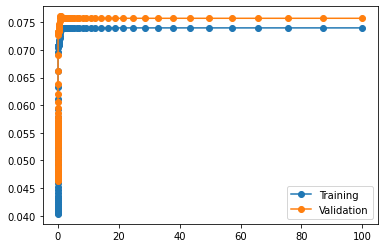

The optimal value of lambda for training is 0.0001
The optimal value of lambda for validation is 0.0001


In [51]:
# Obtain the mean error of each lambda value
val_errors_mean = np.mean(val_errs, axis=0)
train_errors_mean = np.mean(train_errs, axis=0)
# Visualize the results
fig, ax = plt.subplots(1, 1)
plt.plot(lambdas, train_errors_mean, 'o-', label='Training')
plt.plot(lambdas, val_errors_mean, 'o-', label='Validation')
plt.legend()
plt.show()

print(f'The optimal value of lambda for training is {lambdas[np.argmin(train_errors_mean)]}')
print(f'The optimal value of lambda for validation is {lambdas[np.argmin(val_errors_mean)]}')


In [52]:
# Evaluate the model

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1528)

model = Lasso(alpha=lambdas[np.argmin(val_errors_mean)])
model.fit(X_train, y_train)
joblib.dump(model, "./models/lasso_reg_model.sav")
y_hat = model.predict(X_val)
MSE = mean_squared_error(y_val, y_hat)
print(f'MSE for Lasso regression is {MSE}')
num_non_zero = np.sum(np.array(model.coef_) != 0)
print(f'There are {num_non_zero} non zero coefficients')
acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')

MSE for Lasso regression is 0.040556306358943854
There are 165 non zero coefficients
Accuracy per flight: [ 0.93815504  0.96334536  0.70135725 ...  0.8413084  -0.58341813
  0.67901128]
Total accuracy: 0.37104754163608156


C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\184693393.py:14: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())


### Elastic Net regression

In [53]:
# Define parameters
lambdas = np.logspace(-4, 1, 15)
alphas = np.linspace(0, 1, 10)
K = 5
CV = KFold(n_splits=K)
train_errs = np.zeros([K, len(lambdas), len(alphas)])
val_errs = np.zeros([K, len(lambdas), len(alphas)])
X_standardizer = StandardScaler()
# Perform cross validation to determine best penalization parameter
for i, (train_index, test_index) in enumerate(CV.split(X, y)):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index, :]
    y_test = y.iloc[test_index]


    for ((j, _lambda), (k, _alpha)) in (list(itertools.product(enumerate(lambdas), enumerate(alphas)))):
        model = ElasticNet(alpha=_lambda, l1_ratio=_alpha)
        model.fit(X_train, y_train)

        y_hat = model.predict(X_test)

        val_errs[i, j, k] = mean_squared_error(y_test, y_hat)
        train_errs[i, j, k] = mean_squared_error(y_train, model.predict(X_train))

c:\Users\Grigor\Documents\GitHub\Computational Data Analysis\Assignment 1\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.595e+02, tolerance: 2.045e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Grigor\Documents\GitHub\Computational Data Analysis\Assignment 1\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.857e+01, tolerance: 2.045e-01
  model = cd_fast.enet_coordinate_descent(
c:\

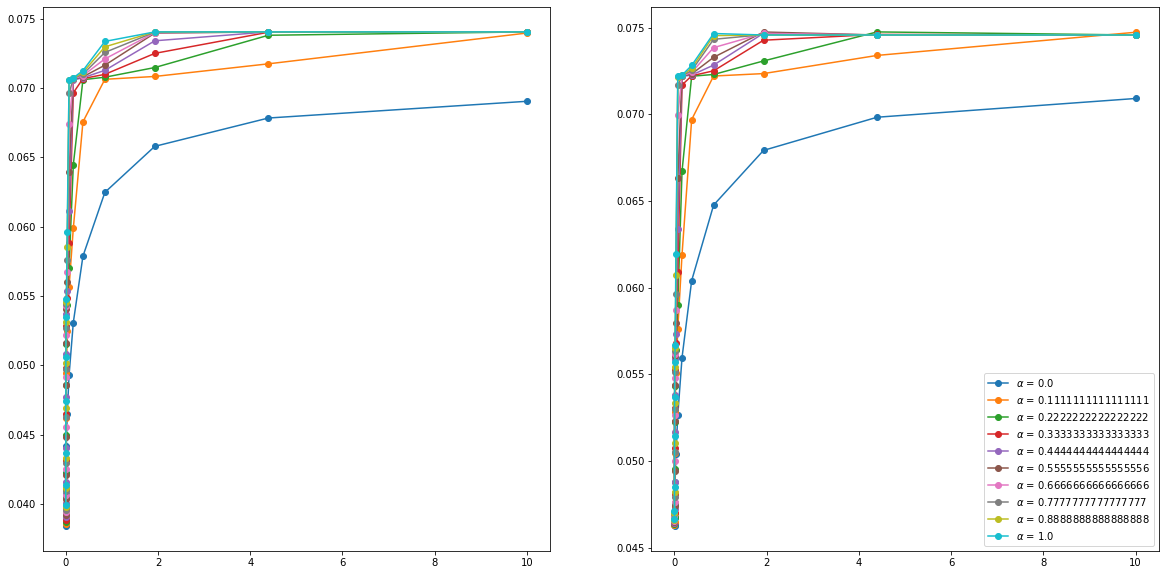

0.0
The optimal value of lambda and alpha for training is [0.0001] and [0.]
The optimal value of lambda and alpha for validation is [0.00051795] and [0.]


In [67]:
# Obtain the mean error of each lambda value
val_errors_mean = np.mean(val_errs, axis=0)
train_errors_mean = np.mean(train_errs, axis=0)
l_train, a_train = np.where(train_errors_mean == train_errors_mean.min())
l_val, a_val = np.where(val_errors_mean == val_errors_mean.min())
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i in range(len(alphas)):
    ax[0].plot(lambdas, train_errors_mean[:, i], 'o-', label=r"$\alpha$" + f' = {alphas[i]}')
    ax[1].plot(lambdas, val_errors_mean[:, i], 'o-', label=r"$\alpha$" + f' = {alphas[i]}')
plt.legend()
plt.show()
print(alphas[a_val][0])
print(f'The optimal value of lambda and alpha for training is {lambdas[l_train]} and {alphas[a_train]}')
print(f'The optimal value of lambda and alpha for validation is {lambdas[l_val]} and {alphas[a_val]}')


In [68]:
# Evaluate the Elastic net model

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1255)
model = ElasticNet(alpha=lambdas[l_val][0], l1_ratio=alphas[a_val][0])
model.fit(X_train, y_train)
joblib.dump(model, "./models/Elastic_net_reg_model.sav")
y_hat = model.predict(X_val)
MSE = mean_squared_error(y_val, y_hat)
print(f'MSE for Elastic net regression is {MSE}')
acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())
print(f'Accuracy per flight: {acc_per_flight}')
# Remove inf values
acc_per_flight = acc_per_flight[np.isfinite(acc_per_flight)]
print(f'Total accuracy: {np.mean(acc_per_flight)}')

MSE for Elastic net regression is 0.03999775355720565
Accuracy per flight: [-1.28649928  0.69053297 -0.77683504 ...  0.86554326  0.65291907
  0.91343958]
Total accuracy: 0.375686458103938


c:\Users\Grigor\Documents\GitHub\Computational Data Analysis\Assignment 1\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.629e+02, tolerance: 2.037e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Grigor\AppData\Local\Temp\ipykernel_17716\2079472132.py:11: RuntimeWarning: divide by zero encountered in true_divide
  acc_per_flight = np.ones(len(y_hat)) - np.abs((y_val.to_numpy() - y_hat) / y_val.to_numpy())
